In [1]:
import sys,os,os.path

sys.path.append("../../")   # cite IC from parent directory
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import tables as tb
import IC.invisible_cities.io.dst_io                           as     dstio
import IC.invisible_cities.io.mcinfo_io as mcio
from    IC.invisible_cities.core.core_functions   import shift_to_bin_centers
import iminuit,probfit

import scipy.special as special
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

In [7]:
#adding here ROI
emin = 1.5
emax = 1.7

def plot_hist(df, column = 'energy', binning = 20, title = "Energy plot", output = True, fill = True, label = 'default', x_label = 'energy (MeV)', range = 0, data = False):
    '''
    Print a histogram of energy from our dataframe,.
    '''
    # for simplicity/readability, scoop out the relevant columns from the pandas dataframe.
    energy_vals = df[column].to_numpy()

    if (range==0):
        range = (np.min(energy_vals), np.max(energy_vals))

    # control viewing of hist
    if (fill == True):
        cnts, edges, patches = plt.hist(energy_vals, bins = binning, label = label, range = range)
    else:
        cnts, edges, patches = plt.hist(energy_vals, bins = binning, label = label, histtype='step', linewidth = 2, range = range)
    plt.title(title)
    plt.ylabel("events")
    plt.xlabel(x_label)
    plt.yscale('log')
    if (output==True):
        plt.show()
    if (data==True):
        return (cnts, edges, patches)
    else:
        return


def load_data(folder_path):
    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # NOTE Break this section up, its annoying like this.
    dfs = []
    df_trs = []
    df_ems = []
    i = 0
    end = len(file_names)
    # create massive dataframe with all of them
    for file in file_names:
        file_path = folder_path + file
        df = dstio.load_dst(file_path, 'Tracking', 'Tracks')
        dfs.append(df)
        # include MC particles (boooo takes ages)

        # collecting the correct components of the file, not exactly sure how this works
        df_ps = pd.read_hdf(file_path, 'MC/particles')
        #df_ps = df_ps[df_ps.creator_proc == 'conv']
        # collecting event map
        df_em = mcio.load_eventnumbermap(file_path).set_index('nexus_evt')
        df_trs.append(df_ps)
        df_ems.append(df_em)
        i += 1

        if (i%1000 == 0):
            print(i)

    tracks = pd.concat(dfs, axis=0, ignore_index=True)

    particles = pd.concat(df_trs, ignore_index=True)
    eventmap = pd.concat([dt for dt in df_ems])
    # create particle list also

    return (tracks, particles, eventmap)

In [3]:
# load in all the data
folder_path = 'data/isaura_test/'
port1_data = load_data(folder_path)

tracks = port1_data[0]
particles = port1_data[1]
eventmap = port1_data[2]

In [4]:
display(particles)
display(eventmap)


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,2540000,1,Tl208,True,0,397.564026,392.015442,534.536865,0.000000,397.564026,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,none,RadioactiveDecay
1,2540000,4,e-,False,1,397.564026,392.015442,534.536865,0.001609,407.646332,...,0.866701,-0.327340,0.002752,-0.000000,-0.000000,0.000000,0.547042,32.554752,RadioactiveDecay,eIoni
2,2540000,3,anti_nu_e,False,1,397.564026,392.015442,534.536865,0.001609,11181.164062,...,0.723798,-0.865316,0.547861,0.723798,-0.865316,0.547861,1.254116,18684.607422,RadioactiveDecay,Transportation
3,2540000,2,Pb208[3197.711],False,1,397.564026,392.015442,534.536865,0.001609,397.564026,...,-1.590499,1.192656,-0.550613,-0.000000,0.000000,-0.000000,0.000011,0.000000,RadioactiveDecay,RadioactiveDecay
4,2540000,6,gamma,False,2,397.564026,392.015442,534.536865,0.001609,164.141830,...,-0.455762,0.228695,0.282998,-0.000000,0.000000,-0.000000,0.583188,1501.569824,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8041796,2030356,91,e-,False,55,30.259228,426.134430,352.008423,2.193173,30.096209,...,-0.162406,0.015503,-0.008732,0.000000,0.000000,0.000000,0.025482,1.436975,eIoni,eIoni
8041797,2030356,90,e-,False,55,30.279558,429.029327,353.054474,2.120956,30.183689,...,0.064169,0.157650,0.102301,0.000000,-0.000000,-0.000000,0.037231,2.202024,eIoni,eIoni
8041798,2030356,89,e-,False,55,32.744003,438.281555,344.038391,1.840851,32.722652,...,-0.022657,0.085612,0.095038,0.000000,0.000000,-0.000000,0.016253,0.597368,eIoni,eIoni
8041799,2030356,88,e-,False,55,23.930265,443.683899,364.208191,1.648568,23.785473,...,-0.025266,-0.164843,-0.084782,-0.000000,0.000000,-0.000000,0.033170,1.671516,eIoni,eIoni


,evt_number
nexus_evt,
2540000,5080000
2540001,5080002
2540002,5080004
2540003,5080006
2540004,5080008
...,...
2030352,4060704
2030353,4060706
2030354,4060708


In [5]:
display(tracks)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080004,0,0.474018,33.900984,6,3204,3,15.675,-319.325,149.169202,...,153.759638,22.762342,-289.535819,154.954336,0.368737,0.314440,0.209227,14.111111,13.875000,11.455763
1,5080004,1,0.002621,0.000000,1,107,3,72.675,-308.325,151.912540,...,154.619509,77.678952,-303.919042,154.619509,0.002621,0.002621,0.002621,14.111111,13.875000,11.455763
2,5080004,2,0.000310,0.000000,1,16,3,-23.325,-243.325,154.748278,...,154.748278,-21.554647,-241.886992,154.748278,0.000310,0.000310,0.000310,14.111111,13.875000,11.455763
3,5080006,0,0.274218,41.565404,13,4025,3,77.675,446.675,717.947738,...,745.884040,111.194348,462.682357,721.697907,0.118426,0.101983,0.006987,14.545455,14.642857,14.844206
4,5080006,1,0.105549,14.545455,2,971,3,19.675,298.675,339.278625,...,344.631064,35.388069,302.841707,343.998794,0.105549,0.105549,0.105549,14.545455,14.642857,14.844206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155960,4060706,3,0.000792,20.897176,2,47,5,331.675,375.675,376.758080,...,376.758080,347.619732,378.049330,382.498692,0.000599,0.000420,0.000227,14.702703,14.850000,13.879979
155961,4060706,4,0.000218,0.000000,1,16,5,301.675,300.675,385.581000,...,385.581000,303.390768,302.119110,385.581000,0.000218,0.000218,0.000218,14.702703,14.850000,13.879979
155962,4060710,0,0.568012,68.571429,32,8501,1,298.675,274.675,522.659780,...,529.078580,333.898970,280.813202,525.604814,0.141785,0.041648,0.000000,14.200000,13.714286,14.432458
155963,4060712,0,0.894838,102.202468,49,7767,2,-9.325,407.675,332.916150,...,343.656648,18.091208,472.788680,414.211251,0.593538,0.083403,0.000000,14.714286,14.625000,12.914461


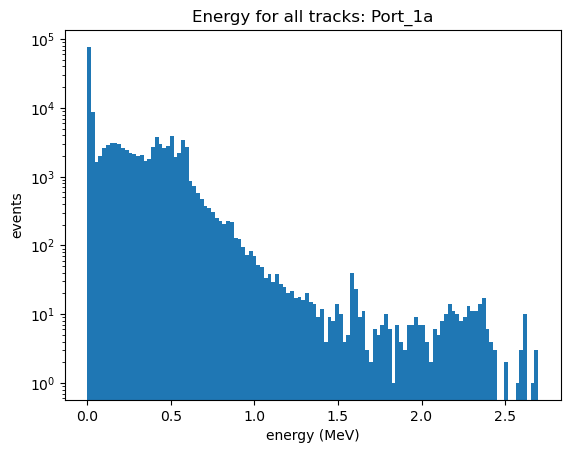

In [8]:
port_1a_hist = plot_hist(tracks, column = 'energy', binning = 120, title = "Energy for all tracks: Port_1a", data = True)


50011


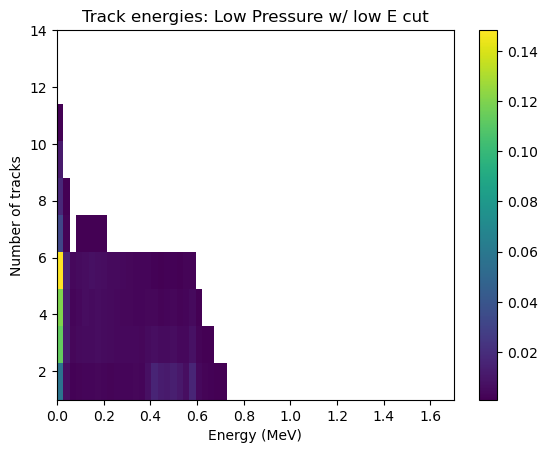

In [11]:
def len_events(df):
    '''
    Returns the number of unique events as len(df) doesn't work in this case
    '''
    length_1 = df['event'].nunique()
    return length_1
# useful to normalize histograms
def get_weights(data, norm):
    if norm:
        return np.repeat(1.0/len(data), len(data))
    else:
        return np.repeat(1.0, len(data))


print(len_events(tracks))

track_energy = tracks.energy
track_no = tracks.numb_of_tracks
# normalise
weights = get_weights(track_energy, True)
#plt.hist2d(track_energy, track_no, bins=(50, 20), cmin=0.001)
plt.hist2d(track_energy, track_no, weights = weights, bins=(100, 10), cmin=0.001)
plt.title("Track energies: Low Pressure w/ low E cut")
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of tracks')
plt.xlim([0,1.7])
plt.colorbar()
plt.show()

In [12]:
def remove_low_E_events(df, energy_limit = 0.05):
    '''
    Remove low energy tracks, add their energy back to the first
    track and then update 'numb_of_tracks' to be up to date
    '''

    tracks_test = df.copy(deep=True)

    # take events with lower than 50 keV, 0.05 MeV
    condition = (tracks_test.energy < energy_limit)
    summed_df = tracks_test[condition].groupby('event')['energy'].sum().reset_index()

    # merge these as a new column
    merged_df = pd.merge(tracks_test, summed_df, on='event', suffixes=('', '_sum'))

    # add this summed energy to first column
    merged_df['energy'] = merged_df.apply(lambda row: (row['energy'] + row['energy_sum']) if row.name == merged_df[merged_df['event'] == row['event']].index[0] else row['energy'], axis=1)

    # drop energy sum column
    result_df = merged_df.drop('energy_sum', axis = 1)

    # then remove all tracks below the energy threshold
    condition_upper = (result_df.energy > energy_limit)
    remove_low_E = result_df[condition_upper]

    # count the number of events identified with unique event, and change numb_of_tracks to reflect this
    event_counts = remove_low_E['event'].value_counts(sort = False)

    # apply this to numb_of_tracks
    remove_low_E['numb_of_tracks'] = remove_low_E['event'].map(event_counts)

    return remove_low_E

In [13]:
low_e_cut_tracks = remove_low_E_events(tracks)

/tmp/ipykernel_45394/261361389.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remove_low_E['numb_of_tracks'] = remove_low_E['event'].map(event_counts)


39308


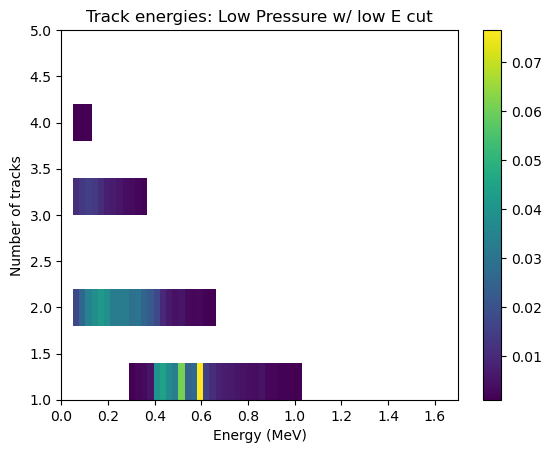

In [14]:
print(len_events(low_e_cut_tracks))

track_energy = low_e_cut_tracks.energy
track_no = low_e_cut_tracks.numb_of_tracks
# normalise
weights = get_weights(track_energy, True)
#plt.hist2d(track_energy, track_no, bins=(50, 20), cmin=0.001)
plt.hist2d(track_energy, track_no, weights = weights, bins=(100, 10), cmin=0.001)
plt.title("Track energies: Low Pressure w/ low E cut")
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of tracks')
plt.xlim([0,1.7])
plt.colorbar()
plt.show()